C:\Users\asia\AppData\Local\Temp\ipykernel_32092\3161455834.py:52: DeprecationWarning: Flip is deprecated. Consider using HorizontalFlip, VerticalFlip, RandomRotate90 or D4.
  A.Flip(p=0.5),


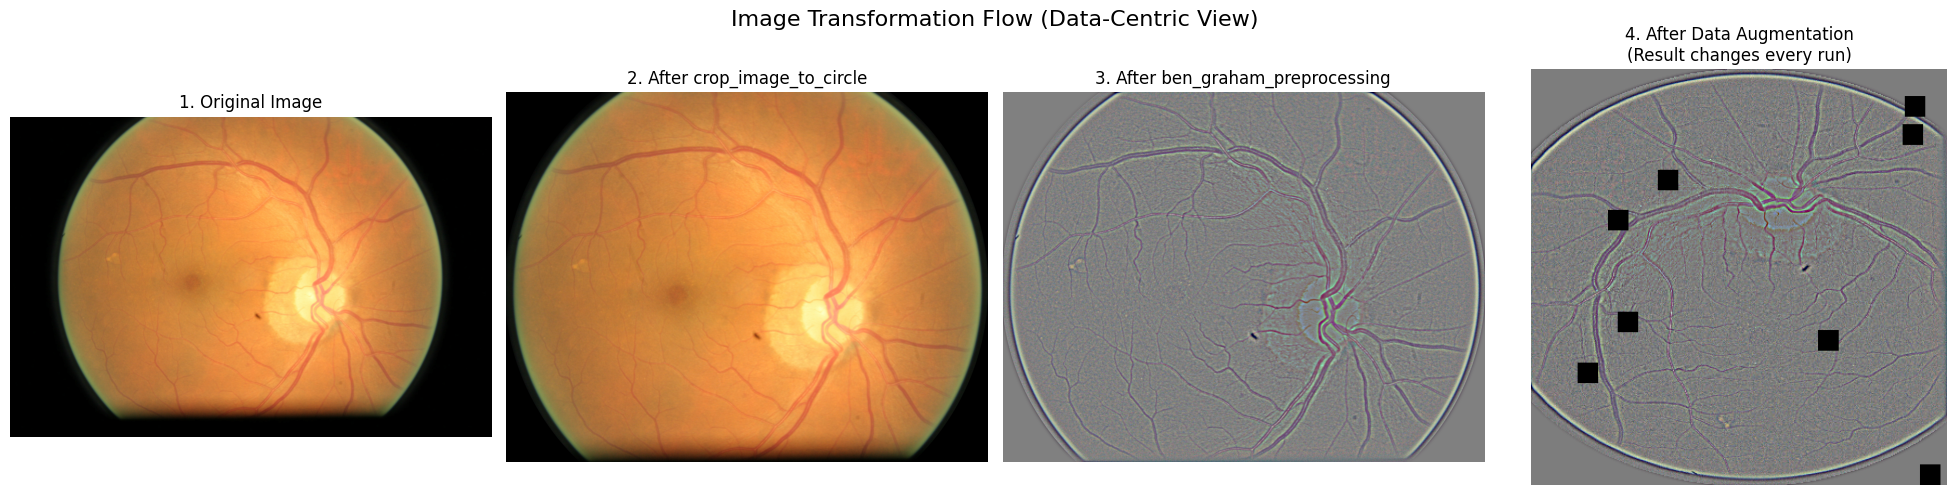

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ====================================================
# 시각화할 이미지 선택
# ====================================================
# train_cleaned.csv 파일에서 시각화하고 싶은 이미지의 경로를 복사하여 붙여넣으세요.
# 예시: "data/images/trainW551_left.jpeg"
# 이 경로의 이미지가 존재해야 합니다.
SAMPLE_IMAGE_PATH = "data/images/train/556_left.jpeg" 
IMG_SIZE = 384

# ====================================================
# 메인 학습 스크립트의 전처리/증강 함수를 그대로 가져옵니다.
# ====================================================

def crop_image_to_circle(image):
    if image.ndim == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray_image = image
    blurred = cv2.GaussianBlur(gray_image, (0,0), 10)
    _, thresh = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return image
    cnt = max(contours, key=cv2.contourArea)
    (x, y), radius = cv2.minEnclosingCircle(cnt)
    center = (int(x), int(y))
    radius = int(radius)
    mask = np.zeros(image.shape[:2], dtype="uint8")
    cv2.circle(mask, center, radius, 255, -1)
    x, y, w, h = cv2.boundingRect(cnt)
    cropped_image = image[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]
    final_image = cv2.bitwise_and(cropped_image, cropped_image, mask=mask)
    return final_image

def ben_graham_preprocessing(image, sigmaX=10):
    processed_image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4, 128)
    return processed_image

def get_transforms_for_visualization(img_size):
    # 시각화를 위해 Normalize와 ToTensorV2는 제외하고 증강 부분만 가져옵니다.
    return A.Compose([
        A.Resize(img_size, img_size),
        A.RandomRotate90(p=0.5), 
        A.Flip(p=0.5), 
        A.Transpose(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.7),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.CoarseDropout(max_holes=8, max_height=img_size//20, max_width=img_size//20, 
                        min_holes=5, fill_value=0, p=0.5),
    ])

# ====================================================
# 시각화 실행 함수
# ====================================================
def visualize_preprocessing_flow():
    """
    하나의 이미지가 겪는 전체 전처리 및 증강 과정을 단계별로 시각화합니다.
    """
    try:
        # 1. 원본 이미지 로딩
        original_image = cv2.imread(SAMPLE_IMAGE_PATH)
        if original_image is None:
            print(f"오류: '{SAMPLE_IMAGE_PATH}' 경로에서 이미지를 찾을 수 없습니다.")
            return
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # 2. 1차 가공: 원형 자르기
        cropped_image = crop_image_to_circle(original_image)

        # 3. 2차 가공: Ben Graham 전처리
        ben_graham_image = ben_graham_preprocessing(cropped_image)
        
        # 4. 3차 가공: 데이터 증강 (결과는 매번 달라짐)
        augmentations = get_transforms_for_visualization(IMG_SIZE)
        augmented_image = augmentations(image=ben_graham_image)['image']

        # 5. Matplotlib을 사용하여 결과 시각화
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        plt.suptitle("Image Transformation Flow (Data-Centric View)", fontsize=16)

        axes[0].imshow(original_image)
        axes[0].set_title("1. Original Image")
        axes[0].axis('off')

        axes[1].imshow(cropped_image)
        axes[1].set_title("2. After crop_image_to_circle")
        axes[1].axis('off')

        axes[2].imshow(ben_graham_image)
        axes[2].set_title("3. After ben_graham_preprocessing")
        axes[2].axis('off')
        
        axes[3].imshow(augmented_image)
        axes[3].set_title("4. After Data Augmentation\n(Result changes every run)")
        axes[3].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"시각화 중 오류가 발생했습니다: {e}")

# ====================================================
# 스크립트 실행
# ====================================================
if __name__ == '__main__':
    visualize_preprocessing_flow()